# Models and results

In [85]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import tools as tl
import numpy as np
import model_full as m
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
%aimport trainer
%aimport tools

---
# How to use the library

Create 2 models:

* **Model1:**  (Image to label)
        - input:  1 channel image of 14x14 pixels
        - output: a vector of 10 values (representing the 10 labels)
* **Model2:** (label to difference)
        - input: 2 Vector of 10 labels
        - output: a single value, 0 if first label is bigger than second, 1 otherwise
        
To test the dimension of your networks:
```python
    trainer.test_model_size(Model1(),Model2())
```

Then call 
```python
    # Construct a model that takes 2 images and return a single output
    full_model = trainer.CombineNet(Model1(),Model2()) 
    # Construct a model that takes 2 images and return the result and the auxiliary the classes vector
    full_model_aux = trainer.CombineWithLabels(Model1(),Model2())     
``` 

To train a model without auxiliary loss:
```python
    results = train_model(model, # model to train
                          data["train_input"],  # train input
                          data["train_target_dif"].view(-1, 1), # train output
                          data["test_input"],# test input
                          data["test_target_dif"],# test output
                          epochs=<number>,eta=<number>,criterion=<loss_method>)
```

To train a model with auxiliary loss:
```python
    result = train_model_auxiliary_loss(model, # model to train
                                        data["train_input"], # train input
                                        data["train_target_dif"].view(-1,1), # train output
                                        data["train_target_label"], # train class auxiliary labels output
                                        data["test_input"], # test input
                                        data["test_target_dif"], # test output
                                        aux_weight =<number between 0 and 1>, # importance of auxiliary loss
                                        epochs=<number>,eta=<number>,#optionnal argument
                                        criterion=<loss_method>, # loss for output
                                        criterion_aux=<aux_loss_method> # loss for labels
                                       ) 
```

In [17]:
class Example1Model1(nn.Module):
    def __init__(self):
        super(Example1Model1, self).__init__()
        nb_hidden = 200
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2)
        self.fc1 = nn.Linear(9 *9* 64, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        x = F.relu(self.conv3(x))
        
        x = F.relu(self.fc1(x.view(-1, 9*9 * 64)))
        
        x = self.fc2(x)
        return x

In [18]:
class Example1Model2(nn.Module):
    def __init__(self):
        super(Example1Model2, self).__init__()
        self.fc1 = nn.Linear(20, 1)
    
    def forward(self , x):
        x = self.fc1(x.view(-1,20))
        return x

---
# CREATE ALL MODELS FOR IMAGE LABELLING HERE

Don't forget to add a short description and eventually the results in markdown


#### 1) Sigmoid model
Same model as example but with sigmoid activation at the end

In [5]:
class ModelSigmoid_I(nn.Module):
    def __init__(self):
        super(ModelSigmoid_I, self).__init__()
        nb_hidden = 200
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2)
        self.fc1 = nn.Linear(9 *9* 64, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        x = F.relu(self.conv3(x))
        
        x = torch.sigmoid(self.fc1(x.view(-1, 9*9 * 64)))
        
        x = self.fc2(x)
        return x

In [6]:
class FullyConnected_I(nn.Module):
    def __init__(self):
        super(FullyConnected_I, self).__init__()
        self.fc1 = nn.Linear(14*14, 1000)
        self.fc2 = nn.Linear(1000, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1,14*14)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x),dim=1)
        return x

In [7]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 =nn.Conv2d(1, 6, kernel_size=(3,3))
        self.conv2= nn.Conv2d(6,16,kernel_size=(5,5))
        self.lin1 = nn.Linear(256,120)
        self.lin2 = nn.Linear(120,84)
        self.lin3 = nn.Linear(84,10)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2,stride=2)
        x = F.relu(self.lin1(x.view(-1,256)))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

---
# CREATE ALL MODELS THAT COMPUTE DIFFERENCES FROM LABEL HERE

Don't forget to add a short description and eventually the results in markdown


#### 1) Sigmoid

In [8]:
class ModelSigmoid_L(nn.Module):
    def __init__(self):
        super(ModelSigmoid_L, self).__init__()
        self.fc1 = nn.Linear(20, 1)
    
    def forward(self , x):
        x = torch.sigmoid(self.fc1(x.view(-1,20)))
        return x

In [9]:
class FullyConnected_II(nn.Module):
    def __init__(self):
        super(FullyConnected_II, self).__init__()
        self.fc1 = nn.Linear(20, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1,20)))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [84]:
class ArgMax(nn.Module):
    def __init__(self):
        super(ArgMax, self).__init__()

    def forward(self, x):
        x = x.argmax(dim=2)
        x = x[:, 0] - x[:, 1]
        x = -x.sign()
        x = (x + 2) / 2
        x = x.float()
        return x.view(-1,1)

---
# Train Here



In [15]:
data = trainer.load_and_process_data(1000)

#### 1) Linear non-shared weight no auxiliary loss

In [50]:
model = m.CombineNet(FullyConnected_I(),FullyConnected_II())

trainer.test_model_size(FullyConnected_I(),FullyConnected_II())

results = trainer.train_model(model, data["train_input"], data["train_target_dif"].view(-1, 1),
                              data["test_input"],data["test_target_dif"], epochs=100,eta=1e-4, criterion=nn.BCELoss())

In [51]:
print(results[2].min())

225.0


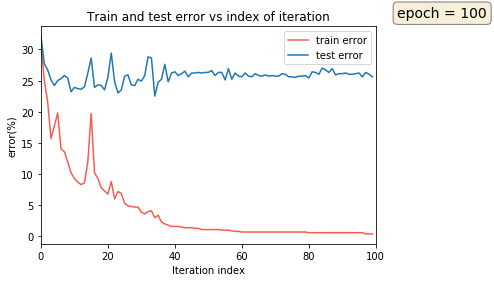

In [52]:
tools.plot(results[1],results[2])

#### 2) Convolutionnal Net no auxiliary loss

In [39]:
model_2 = m.CombineNet(LeNet5(),FullyConnected_II())
trainer.test_model_size(LeNet5(),FullyConnected_II())
results_2 = trainer.train_model(model_2, data["train_input"], data["train_target_dif"].view(-1, 1),
                              data["test_input"],data["test_target_dif"], epochs=40,eta=1e-4)

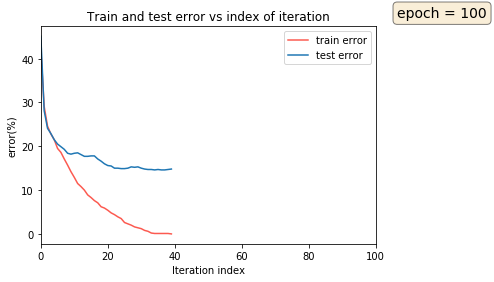

In [40]:
tools.plot(results_2[1],results_2[2])

#### 3) Linear non-shared weight with auxiliary loss

In [41]:
model_3 = m.CombineWithLabels(FullyConnected_I(),FullyConnected_II())
trainer.test_model_size(FullyConnected_I(),FullyConnected_II())

results_3 = trainer.train_model_auxiliary_loss(model_3, data["train_input"], data["train_target_dif"].view(-1, 1),data["train_target_label"],
                              data["test_input"],data["test_target_dif"], epochs=40,eta=1e-4, criterion=nn.BCELoss())

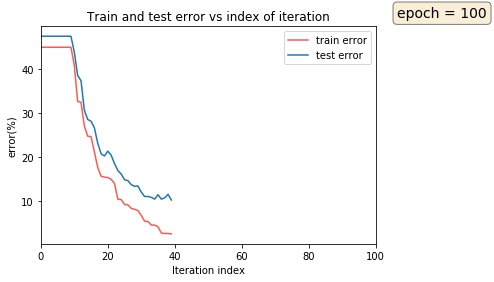

In [42]:
tools.plot(results_3[1],results_3[2])


plot error_test against aux_weight

In [103]:
from IPython.display import clear_output

aux_w =[0.1,0.3,0.5,0.7,0.8,0.85,0.9,0.95,0.97,0.98,0.99,0.995,0.999]
bests_err = np.zeros(len(aux_w))

for i,w in enumerate(aux_w):
    print("It", i)
    model_ = m.CombineWithLabels(FullyConnected_I(),FullyConnected_II())

    results_ = trainer.train_model_auxiliary_loss(model_, data["train_input"], data["train_target_dif"].view(-1, 1),data["train_target_label"],
                                  data["test_input"],data["test_target_dif"],aux_weight=w, epochs=40,eta=1e-4)
    bests_err[i]=results_[2].min() / 10
    clear_output()
  

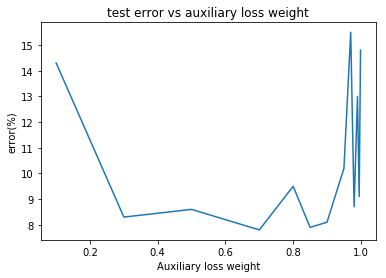

In [104]:
  
plt.title("test error vs auxiliary loss weight")
plt.xlabel("Auxiliary loss weight")
plt.ylabel("error(%)")
plt.xscale("linear")
plt.plot(aux_w,bests_err)
    

#### 4) Convolutionnal Net with auxiliary loss

In [107]:
model_4 = m.CombineWithLabels(LeNet5(),FullyConnected_II())
trainer.test_model_size(LeNet5(),FullyConnected_II())
results_4 = trainer.train_model_auxiliary_loss(model_4, data["train_input"], data["train_target_dif"].view(-1, 1),data["train_target_label"],
                                       data["test_input"],data["test_target_dif"],aux_weight=0.999, epochs=40,eta=5e-3)

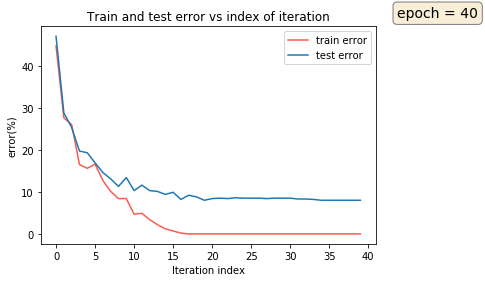

In [108]:
tools.plot(results_4[1],results_4[2])

In [105]:
from IPython.display import clear_output

aux_w =[0.1,0.3,0.5,0.7,0.8,0.85,0.9,0.95,0.97,0.98,0.99,0.995,0.999]
bests_err = np.zeros(len(aux_w))

for i,w in enumerate(aux_w):
    print("It", i)
    model_ = m.CombineWithLabels(LeNet5(),FullyConnected_II())

    results_ = trainer.train_model_auxiliary_loss(model_, data["train_input"], data["train_target_dif"].view(-1, 1),data["train_target_label"],
                                  data["test_input"],data["test_target_dif"],aux_weight=w, epochs=40,eta=1e-4)
    bests_err[i]=results_[2].min() / 10
    clear_output()

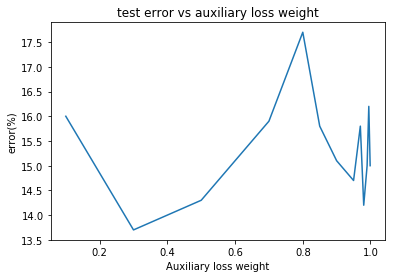

In [106]:
plt.title("test error vs auxiliary loss weight")
plt.xlabel("Auxiliary loss weight")
plt.ylabel("error(%)")
plt.xscale("linear")
plt.plot(aux_w,bests_err)

#### 5)  Use only labels

In [80]:
model_5 = m.CombineWithLabels(LeNet5(),ArgMax())
trainer.test_model_size(LeNet5(),ArgMax())
results_5 = trainer.train_model_auxiliary_loss(model_5, data["train_input"], data["train_target_dif"].view(-1, 1),data["train_target_label"],
                                       data["test_input"],data["test_target_dif"],aux_weight=0.999, epochs=40,eta=5e-3)

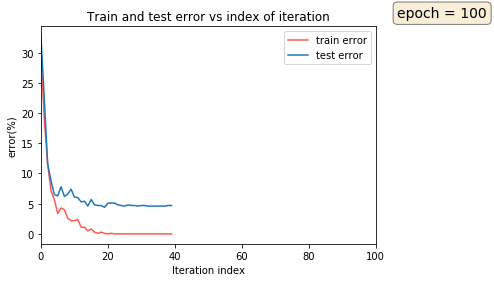

In [81]:
tools.plot(results_5[1],results_5[2])

# Draft


In [67]:

from IPython.display import clear_output

def showErrors(model, input_, target,mini_batch_size=100):

    for b in range(0, input_.size(0), mini_batch_size):
        ims = input_.narrow(0, b, mini_batch_size)
        output = model(ims)
        labels=None
        if len(output) ==2:
            labels=output[1]
            output =output[0]
        
        target_batch = target.narrow(0, b, mini_batch_size)
        
        for k in range(output.shape[0]):
            result = 1
            if output[k][0] < 0.5:
                result = 0
            if target_batch[k] != result:
                print("Expected :" , target_batch[k])
                print("model gives :" ,output[k][0] )
                if labels is not None:
                    print(labels[k][0].argmax())
                    print(labels[k][0])
                    print()
                    
                    print(labels[k][1].argmax())
                    print(labels[k][1])
                tools.vizualizeIms(ims[k])
                clear_output(wait=True)
                x = input()
                if(x == "end"):
                    return



In [83]:
showErrors(model_5,data["test_input"],data["test_target_dif"])

KeyboardInterrupt: Interrupted by user

In [76]:
x = torch.Tensor([[[0,0,0.5,0,0.8,0,0],[0,0.7,0.2,0.4,0.9,0,0]],[[0,0,0.5,1,0.8,0,0],[0,0.7,0.2,0.4,0.3,0.9,0]]])
x = x.argmax(dim=2)
x = x[:,0] - x[:,1]
x = -x.sign()
x = (x+2)/2
x

tensor([1, 1])